# Adversarial Patch Notebook

This notebook demonstrates an Adversarial Patch attack on a YOLOv5 model.

## Table of Contents
1. [Setup](#Setup)
2. [Imports](#Imports)
3. [Configuration](#Configuration)
4. [Creation of the Estimator](#Creation-of-the-Estimator)
5. [Function Definition](#Function-Definition)
6. [Predictions on Original Images](#Predictions-on-Original-Images)
7. [Choice of the Attack](#Choice-of-the-Attack)
8. [Generation of the Attack](#Generation-of-the-Attack)
9. [After Attack Predictions](#After-Attack-Predictions)

## Setup
To use it, you need to have a Python environment activated with the packages listed in the `requirements.txt` file.

## Imports

**Note:** If you need to rerun the notebook after the modification of an external file, please restart the kernel first.

In [1]:
from utils.utils import nms_on_predictions, load_config
from utils.utils_detector_yolo import UtilsDetectorYolo

from attacks.white_boxes.local_adversarial_patch_pytorch import LocalAdversarialPatchPytorch

/home/augustinl/benchmark/.venv/lib/python3.12/site-packages/yolov5/utils/general.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
/home/augustinl/benchmark/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

To load a configuration, you need to have your own json file with a correct configuration in it. For this example, the configuration file is `data/configs/pgd_default_config.json`. If you want to create your own, you have to set all these attributes:

- **`THRESHOLD`**: The confidence threshold used to filter model predictions with higher scores.
- **`TARGET_CLASS`**: The name of the target class for the attack. It must be in the list of classes of the model. The values are defined in the list `COCO_INSTANCE_CATEGORY_NAMES` in the `utils` file of your model. It must be `None` if you want an **untargeted attack**.
    - If you want an untargeted attack, set this parameter to ''.
- **`VICTIM_CLASS`**: Similar to the target class, this specifies the name of the class you want to attack. 
    - Set this to `''` if you want to attack all the classes of the model.
- **`BATCH_SIZE`**: The number of images to include in the dataset of the model. It is the number of images used to compute the efficiency of the attack. The actual number of images may be less than this value if the dataset contains fewer images with a victim in it.
- **`IOU_THRESHOLD`**: The threshold used for NMS (Non-Maximum Suppression) in the model. It is used to filter the predictions of the model.
- **`MAX_ITER`**: The number of iterations to train the attack.
- **`TARGET_LOCATION`**: The location of the patch in the image with the format `[y, x]`. It is a list of two integers representing the x and y coordinates of the top-left corner of the patch.
- **`TARGET_SHAPE`**: The shape of the target to apply to the image in the format [C, H, W].
- **`IMAGES_TO_DISPLAY`**: The number of images to display in the notebook. You can modify this variable to change the number of images displayed. **Be aware that displaying too many images can slow down the notebook.**
- **`FOLDER_NAME`**: The name of the folder containing the images used in the notebook.

In [2]:
config = load_config("../data/configs/adv_patch_default_config.json")

## Creation of the Estimator

The estimated object detector is created using a torchvision model as the base. The only available model is:

| Name                       | Class                    | Type             | Dataset       |
|----------------------------|--------------------------|------------------|---------------|
| **Yolov5s pretrained**     | `UtilsDetectorYolo`      | Object Detection | COCO 2017     |

During the creation of the estimator, the following steps are performed:
1. **Load the model** (with the adapted wrapper if needed).
2. **Load the dataset** into the variable `estimator.images`. This dataset is composed of a variety of images, with only the victim class in it.

In [3]:
estimated_object_detector = UtilsDetectorYolo(config.BATCH_SIZE, config.THRESHOLD, config.VICTIM_CLASS)

IMAGES = estimated_object_detector.images

Loading the model
Loading the dataset
5 images with victim class found
Number of images: 5


## Function Definition

The function `predict` is defined to generate the predictions of the models on the desired dataset.
It generates the predictions of the model on the dataset and saves the images with the predictions in the folder `data/{dataset_name}/` with the name `file_name`. The predictions are filtered with the `config.THRESHOLD` defined in the configuration section and with the `config.IOU_THRESHOLD` defined in the configuration section. 

The function returns the predictions of the model on the images and the count of victims in the dataset.

In [4]:
def predict(images, estimator, dataset_name, file_name, folder_path):
    # Display original images with detections
    predictions = estimator.estimator.predict(images)
    # Apply NMS
    dets = nms_on_predictions(predictions, iou_threshold=config.IOU_THRESHOLD)

    predictions_list = []
    victim_count = 0
    print(f"Display pictures of the {dataset_name} dataset with original detections")
    for i in range(len(dets)):
        predictions = estimator.extract_predictions(dets[i], config.THRESHOLD)
        estimator.plot_image(
            img=images[i].transpose(1, 2, 0).copy(), 
            boxes=predictions[1], pred_cls=predictions[0], 
            title=file_name+f"_{i}", 
            folder=folder_path, 
            show=(i<config.IMAGES_TO_DISPLAY)
            )
        predictions_list.append(predictions)

        for j in range(len(predictions[0])):
            if predictions[0][j] == config.VICTIM_CLASS:
                victim_count += 1

    return predictions_list, victim_count

## Predictions on Original Images

Display pictures of the original dataset with original detections


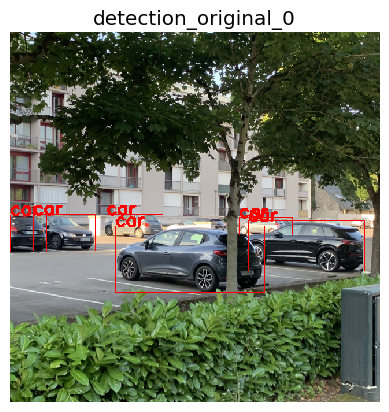

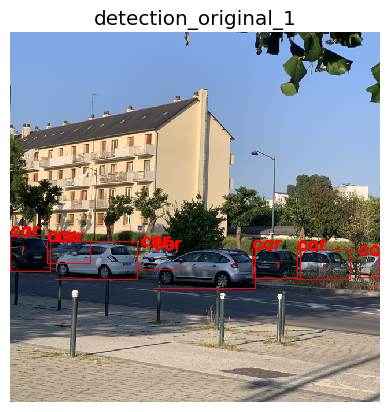

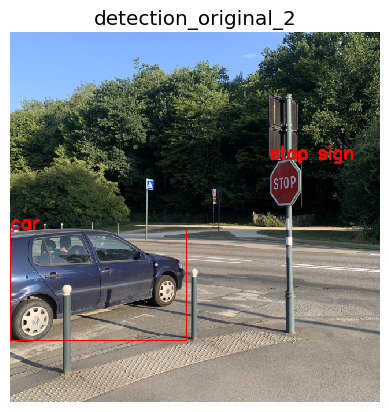

In [5]:
%matplotlib inline

original_predictions, _ = predict(
        images=IMAGES,
        estimator=estimated_object_detector,
        dataset_name=config.FOLDER_NAME,
        file_name=f"detection_{config.FOLDER_NAME}",
        folder_path=f"../data/{config.FOLDER_NAME}/"
        )

## Choice of the Attack

Choose an attack from the following options:

| Name                  | Class                          | Type       |
|-----------------------|-------------------------------|------------|
| **PGD**               | `LocalProjectedGradientDescent` | White Box  |
| **Adversarial Patch** | `LocalAdversarialPatchPytorch` | White Box  |

If you want to test the `LocalAdversarialPatchPytorch` attack, you can use the second Notebook named `notebook_white_box_patch.ipynb`.

**Note**: The `orig_predictions` variable is used to store the predictions of the model before the attack on the dataset used to train the attack. It's used to compute the loss during the training of the attack.

In [6]:
attack = LocalAdversarialPatchPytorch(
    estimator=estimated_object_detector,
    images=IMAGES,
    orig_predictions=original_predictions, 
    target_class=config.TARGET_CLASS
    )

## Generation of the Attack

This section generates the adversarial patch on the `IMAGES` dataset using the original predictions.  
The `TARGET_SHAPE` defines the dimensions of the adversarial patch, and `TARGET_LOCATION` specifies where it should be placed in the image.

In [7]:
%matplotlib inline

# Generate adversarial examples
patch, _ = attack.generate(
    images = IMAGES,
    orig_predictions = original_predictions,
    target_shape = config.TARGET_SHAPE,
    target_location = config.TARGET_LOCATION,
    max_iter = config.MAX_ITER
)

None


Adversarial Patch PyTorch: 100%|██████████| 500/500 [00:30<00:00, 16.31it/s]


### After Attack Predictions

The predictions on the adversarial images are generated using the `estimated_object_detector.predict()` method. The predictions are stored in the variable `attack_predictions` and can be used to compute attack effectiveness metrics.

The method returns the orignal images with a patch applied on it, in the list `adversarial_examples`. The `attack_predictions` list contains the model's predictions for each image. The patched images are saved in the attack's output folder for analysis.

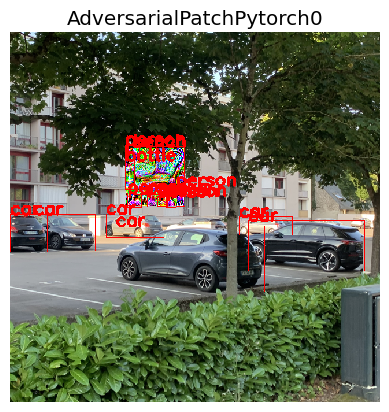

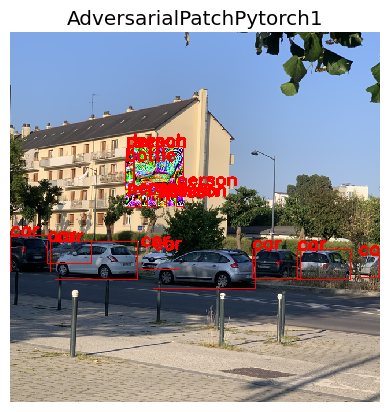

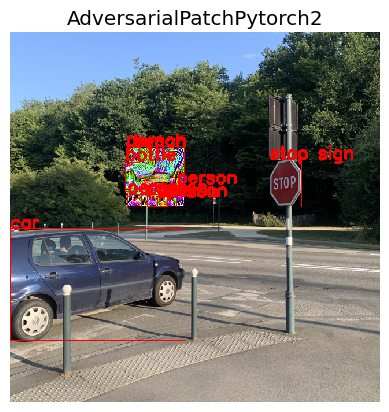

In [8]:
# Apply the attack to the images 
attack_predictions, adversarial_examples = attack.apply_attack_to_image(
    image=IMAGES,
    train_on=len(IMAGES),
    threshold=config.THRESHOLD,
)